In [1]:
import numpy as np                          # numerical computing
from scipy.integrate import quad            # numerical integration
import scipy.optimize                       # Root finding routines
import matplotlib.pyplot as plt             # plotting

# Format output so floats have 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
def cdfX(x, xBar, gamma):
    '''The cdf of the productivity distribution.'''
    return 1-(xBar/x)**gamma

def pdfX(x, xBar, gamma):
    '''The pdf of the productivity distribution.'''
    return gamma * xBar**gamma * x**(-gamma-1)


def priceIntegrand(x, rho, xBar, gamma):
    '''The integrand for the aggregate price index. Integrate this to compute P.'''
    return x**(rho/(1-rho)) * pdfX(x, xBar, gamma)

def computeP(xHat, i, mu, tau, rho, xBar, N, gamma):
    '''Computes the aggregate price index given guesses of P and Pi.'''
    temp = 0
    for j in range(0,N):
        temp += mu[j]*(tau[i,j]/rho)**(-rho/(1-rho)) * quad(priceIntegrand, xHat[i,j], np.inf, args=(rho, xBar[j], gamma))[0]

    return temp**(-(1-rho)/rho);

In [3]:
def profitIntegrand(x, rho, xBar, gamma):
    '''This is the same as the integrand in the price index, but written separately for clarity. 
    Integrate this to compute Pi.'''
    return x**(rho/(1-rho)) * pdfX(x, xBar, gamma)

def computePi(xHat, guessP, i, mu, tau, rho, xBar, N, gama, alpha, inc, k):
    '''Computes aggregate profits given the guess of P and Pi'''

    Pi=0
    for j in range(0,N):
        Pi += mu[i]*(1-rho)*alpha*inc[j]*(tau[i,j]/guessP[j]/rho)**(-rho/(1-rho))*quad(profitIntegrand, xHat[i,j], np.inf, args=(rho, xBar[i], gamma))[0]
        Pi -=  mu[i] * k[i,j] * ( 1 - cdfX(xHat[i,j], xBar[i], gamma) )    
    
    return Pi

In [4]:

def compute_cutoffs(N, rho, alpha, P, tau, w, inc):
    '''Given P (and Pi, in inc) compute the breakeven productivity for each market.'''
    xHat = np.empty((N,N))
    
    for j in range(0,N):
        tt = ((1-rho)*alpha* inc[j])**((1-rho)/(-rho)) / (rho*P[j])
        
        for i in range(0,N):
            xHat[i,j] = tau[i,j]*w[i] * tt * k[i,j]**((1-rho)/rho)
    
    return xHat

In [5]:
def sysEq(guess, mu, tau, rho, xBar, N, gamma, alpha, w, L, k):
    '''Solve this system of equations (in Pi and P) to find equilibrium.'''
    
    guessP, guessPi = guess[0:N], guess[N:]
    inc = w*L + guessPi
    
    # Given guesses for P and Pi, compute the cutoff productivities for each i,j
    xHat = compute_cutoffs(N, rho, alpha, guessP, tau, w, inc)
    
    # Return the difference between the guesses for P and Pi, and the P and Pi implied by the guesses
    # We have an equilibrium when these are zero
    err = np.empty(2*N)
    for i in range(0,N):
        err[i]   = computeP (xHat, i, mu, tau, rho, xBar, N, gamma) - guessP[i]
        err[N+i] = computePi(xHat, guessP, i, mu, tau, rho, xBar, N, gamma, alpha, inc, k) - guessPi[i]
    
    return err

In [6]:
def sales_integrand(x, tau, rho, xBar, gamma): 
    '''Integrate this to compute the aggregate sales'''
    return (tau/(rho*x))**(-1/(1-rho))/(rho*x)*pdfX(x, xBar, gamma)

def sales(P, mu, alpha, inc, rho, xHat, xBar, gamma, tau):
    '''Mass of firms from i producing for market j and their sales.'''
    
    mass = np.empty((N,N))
    sales = np.empty((N,N))
    
    for i in range(0,N):
        for j in range(0,N):
            mass[i,j] = mu[i] * ( 1-cdfX(xHat[i,j], xBar[i], gamma) )
            sales[i,j] = (mu[i]*alpha*inc[j]*P[j]**(rho/(1-rho))*
                          quad(sales_integrand, xHat[i,j], np.inf, args=(tau[i,j], rho, xBar[i], gamma))[0])
        
    return mass, sales

In [7]:
def report_results(sol, w, L, N, rho, alpha, tau, gamma, xBar):
    '''Print out equilibrium objects of interest. Return the sales matrix for further use.'''
    P, Pi = sol[0:N], sol[N:]
    inc = w*L + Pi
    xHat = compute_cutoffs(N, rho, alpha, P, tau, w, inc)
    m, s = sales(P, mu, alpha, inc, rho, xHat, xBar, gamma, tau)

    print('1. The cutoff productivities are:\n', xHat)
    print('\n2. The masses of differentiated imported goods consumed are {0:.4f} and {1:.4f}.'.format(m[0,1], m[1,0]))

    print('\n3. The masses of differentiated domestic goods consumed are {0:.4f} and {1:.4f}.'.format(m[0,0], m[1,1]))
    print('\n4. The CES aggregate price indexes for differentiated goods are', P)
    print('\n5. The f.o.b. value of imports is {0:.4f} and {1:.4f}.'.format(s[0,1], s[1,0]))
    print('\n6. The value of consumption from domestic firms is {0:.4f} and {1:.4f}.'.format(s[0,0], s[1,1]))
    
    return s

In [9]:
def elasticity(sales_high, sales_low, tau_high, tau_low):
    '''Returns the elasticity of imports with respect to tariffs. I multiply by -1 to report positive numbers.'''
    num = (sales_low[1,0]/sales_low[0,0]) / (sales_high[1,0]/sales_high[0,0]) -1
    den = tau_low[1,0]/tau_high[1,0] - 1
    return -1*(num/den + 1)

In [10]:
N = 2                        # number of countries
L = np.array([1, 1])         # country sizes        
mu = np.array([1, 1])        # mass of potential firms
rho = 0.8                    # 1/(1-rho) is the elasticity of substitution between varieties  
alpha = 0.4                  # share of spending on differentiated goods
gamma = 6.5                  # shape parameter of Pareto distribution
w = np.array([1, 1])         # wages
xBar=np.array([1, 1])        # lower bound on productivity

In [13]:
# Set up parameters
tau_high = np.array([[1.00, 1.15], [1.15, 1.00]])  #iceberg trade costs  
k = np.array([ [0.1, 0.2], [0.2, 0.1]]) # fixed cost to serve market

# Solve the model
guess = np.array([1.0, 1.0, 0.106, 0.106])  # [home price, foreign price, home profit, foreign profit]
sol  = scipy.optimize.newton_krylov(lambda g: sysEq(g, mu, tau_high, rho, xBar, N, gamma, alpha, w, L, k), guess, f_tol = 0.0001)

# Report reults
sales_high = report_results(sol, w, L, N, rho, alpha, tau_high, gamma, xBar)

1. The cutoff productivities are:
 [[1.233 1.686]
 [1.686 1.233]]

2. The masses of differentiated imported goods consumed are 0.0335 and 0.0335.

3. The masses of differentiated domestic goods consumed are 0.2566 and 0.2566.

4. The CES aggregate price indexes for differentiated goods are [1.059 1.059]

5. The f.o.b. value of imports is 0.0758 and 0.0758.

6. The value of consumption from domestic firms is 0.3335 and 0.3335.


c. Gains from trade.

In [15]:
# Set up parameters
tau_low = np.array([[1.00, 1.00], [1.00, 1.00]])  #iceberg trade costs

# Solve the model
guess = np.array([1.0, 1.0, 0.106, 0.106])  # [home price, foreign price, home profit, foreign profit]
sol  = scipy.optimize.newton_krylov(lambda g: sysEq(g, mu, tau_low, rho, xBar, N, gamma, alpha, w, L, k), guess, f_tol = 0.0001)

# Report reults
sales_low = report_results(sol, w, L, N, rho, alpha, tau_low, gamma, xBar)

1. The cutoff productivities are:
 [[1.285 1.528]
 [1.528 1.285]]

2. The masses of differentiated imported goods consumed are 0.0637 and 0.0637.

3. The masses of differentiated domestic goods consumed are 0.1963 and 0.1963.

4. The CES aggregate price indexes for differentiated goods are [1.016 1.016]

5. The f.o.b. value of imports is 0.1655 and 0.1655.

6. The value of consumption from domestic firms is 0.2552 and 0.2552.


d. Nonlinearities.

In [16]:
# Set up parameters
tau_eps = np.array([[1.00, 1.14999], [1.14999, 1.00]])  #iceberg trade costs

# Solve the model
guess = np.array([1.0, 1.0, 0.106, 0.106])  # [home price, foreign price, home profit, foreign profit]
sol  = scipy.optimize.newton_krylov(lambda g: sysEq(g, mu, tau_eps, rho, xBar, N, gamma, alpha, w, L, k), guess, f_tol = 0.0001)

# Report reults
sales_eps = report_results(sol, w, L, N, rho, alpha, tau_eps, gamma, xBar)

1. The cutoff productivities are:
 [[1.233 1.686]
 [1.686 1.233]]

2. The masses of differentiated imported goods consumed are 0.0335 and 0.0335.

3. The masses of differentiated domestic goods consumed are 0.2566 and 0.2566.

4. The CES aggregate price indexes for differentiated goods are [1.059 1.059]

5. The f.o.b. value of imports is 0.0758 and 0.0758.

6. The value of consumption from domestic firms is 0.3335 and 0.3335.


In [17]:
sig_eps = elasticity(sales_high, sales_eps, tau_high, tau_eps)
print('The elasticity is {0:.3f}, which corresponds to the shape parameter in the Pareto distribution of productivities.'.
      format(sig_eps))

The elasticity is 6.500, which corresponds to the shape parameter in the Pareto distribution of productivities.


In [18]:
# Set up parameters
tau_05 = np.array([[1.00, 1.05], [1.05, 1.00]])  #iceberg trade costs 

# Solve the model
guess = np.array([1.0, 1.0, 0.106, 0.106])  # [home price, foreign price, home profit, foreign profit]
sol  = scipy.optimize.newton_krylov(lambda g: sysEq(g, mu, tau_05, rho, xBar, N, gamma, alpha, w, L, k), guess, f_tol = 0.0001)

# Report reults
sales_05 = report_results(sol, w, L, N, rho, alpha, tau_05, gamma, xBar)

1. The cutoff productivities are:
 [[1.262 1.576]
 [1.576 1.262]]

2. The masses of differentiated imported goods consumed are 0.0519 and 0.0519.

3. The masses of differentiated domestic goods consumed are 0.2198 and 0.2198.

4. The CES aggregate price indexes for differentiated goods are [1.034 1.034]

5. The f.o.b. value of imports is 0.1285 and 0.1285.

6. The value of consumption from domestic firms is 0.2858 and 0.2858.


In [19]:
sig_05 = elasticity(sales_high, sales_05, tau_high, tau_05)
sig_low = elasticity(sales_high, sales_low, tau_high, tau_low)

print('The three elasticities are {0:.3f}, {1:.3f}, and {2:.3f}.'.format(sig_eps, sig_05, sig_low))

The three elasticities are 6.500, 10.252, and 13.203.


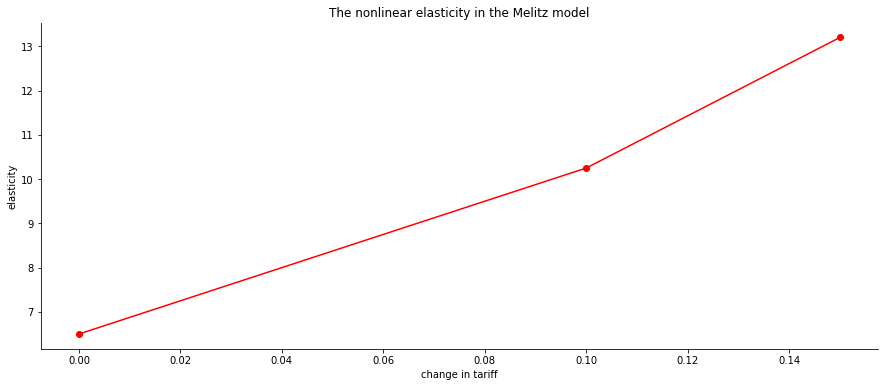

In [20]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot([0.00001, 0.10, 0.15], [sig_eps, sig_05, sig_low], color='red', marker = 'o')

ax.set_ylabel('elasticity')
ax.set_xlabel('change in tariff')
ax.set_title('The nonlinear elasticity in the Melitz model')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()